In [113]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('./Time-series-datasets/electricity.csv')
df.head()

# https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide
# https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [114]:
# 1. Predict demand - univariate
# 2. Combine with temperature and holiday to predict demand - multivariate

In [115]:
targets = ['Demand']
features = ['Time', 'Temperature', 'Holiday']

df['Time'] = pd.to_datetime(df.Time).dt.tz_localize(None) 
df.dtypes

Time           datetime64[ns]
Demand                float64
Temperature           float64
Date                   object
Holiday                  bool
dtype: object

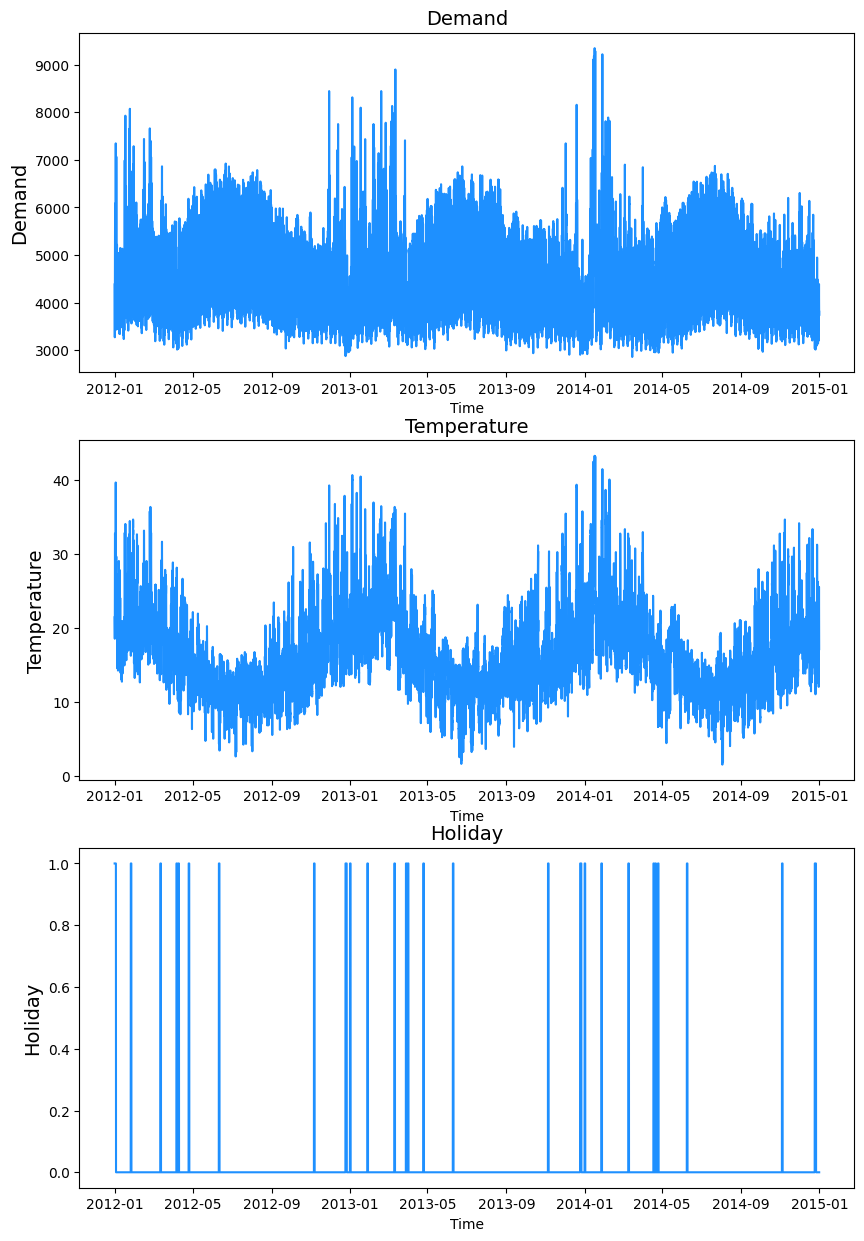

In [116]:
# a. Visualize
# To compelte the data, as naive method, we will use ffill - No Null here
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

for i, column in enumerate(['Demand', 'Temperature', 'Holiday']):
    sns.lineplot(x=df['Time'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    #ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)]) 

In [117]:
# b. Data preprocessing: 
# - Check the order of data: time interval is 30min and the data is already in chronological order
df['delta'] = df['Time'] - df['Time'].shift(1)

print(df[['Time', 'delta']].head())
df.delta.value_counts()
# - Handle missing values: no missing values
# - Smoothing / resampling: up or downsampling

                 Time           delta
0 2011-12-31 13:00:00             NaT
1 2011-12-31 13:30:00 0 days 00:30:00
2 2011-12-31 14:00:00 0 days 00:30:00
3 2011-12-31 14:30:00 0 days 00:30:00
4 2011-12-31 15:00:00 0 days 00:30:00


delta
0 days 00:30:00    52607
Name: count, dtype: int64

Text(0.5, 1.0, 'Daily Demand')

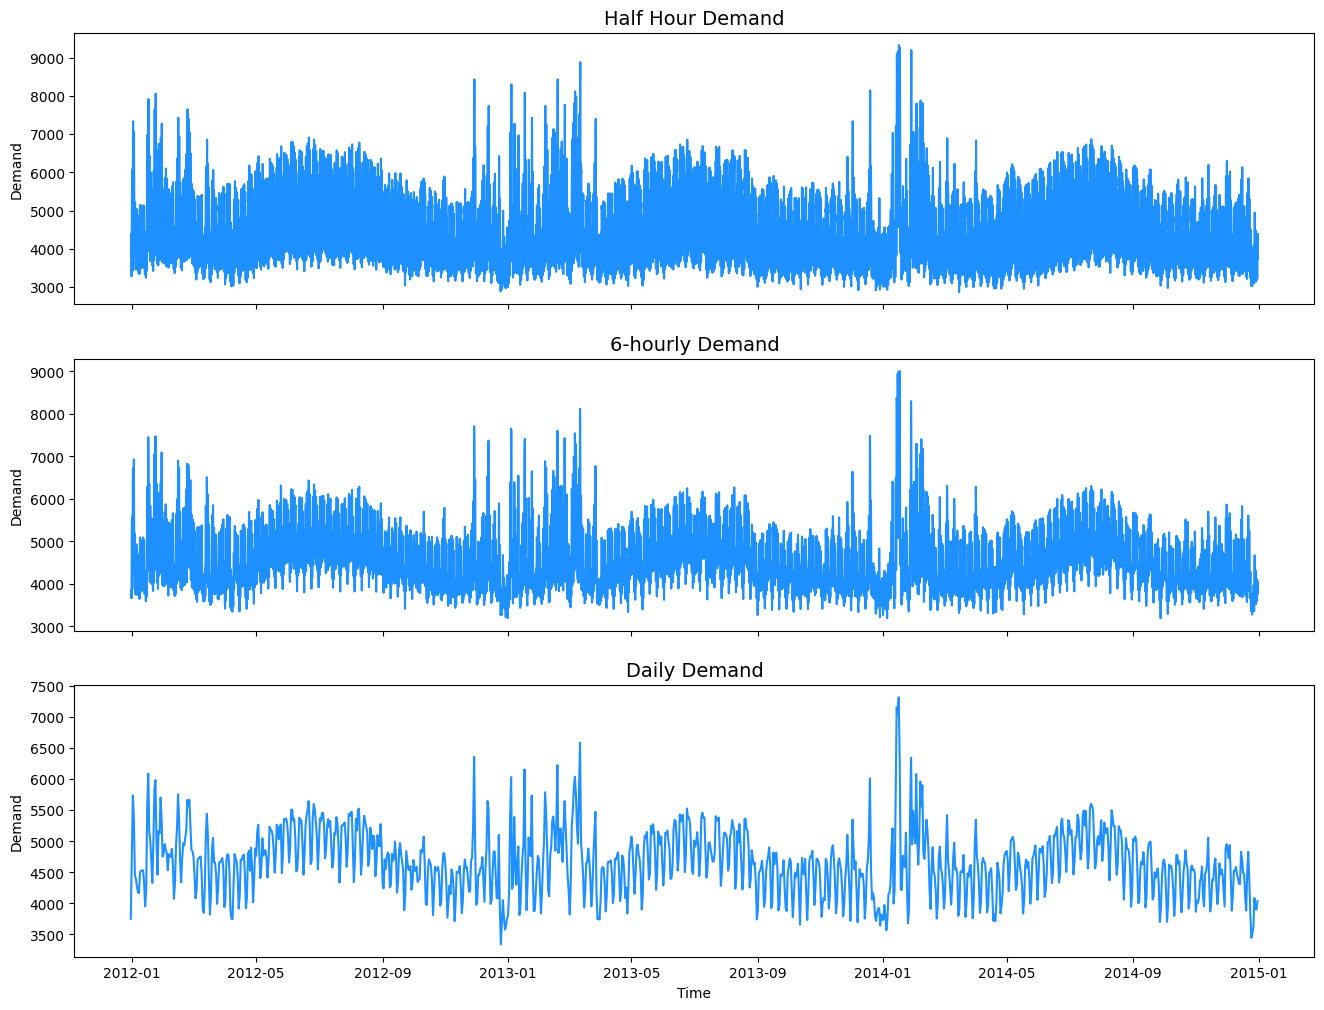

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(16,12))
sns.lineplot(x=df['Time'], y=df['Demand'], color='dodgerblue', ax=ax[0])
ax[0].set_title('Half Hour Demand', fontsize=14)

resampled_df = df[['Time','Demand']].resample('6H', on='Time').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['Time'], y=resampled_df['Demand'], color='dodgerblue', ax=ax[1])
ax[1].set_title('6-hourly Demand', fontsize=14)

resampled_df = df[['Time','Demand']].resample('D', on='Time').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df['Time'], y=resampled_df['Demand'], color='dodgerblue', ax=ax[2])
ax[2].set_title('Daily Demand', fontsize=14)

In [119]:
# As we can see, downsample to daily could smooth the data and help with analysis
downsample = df[features+targets].resample('D', on='Time').mean().reset_index(drop=False)

sample_df = downsample.copy()
sample_df.head()

,Time,Temperature,Holiday,Demand
0,2011-12-31,21.047727,1.000000,3751.442996
1,2012-01-01,26.578125,1.000000,4745.380361
2,2012-01-02,31.751042,0.541667,5739.395602
3,2012-01-03,24.567708,0.000000,5394.902696
4,2012-01-04,18.191667,0.000000,4454.007853


In [120]:
# c. Feature Engineering: read more at https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide
# - Encoding cyclical features: 
# to avoid confusion because of the difference in time, e.g. between two years the month feature jumps from 12 (December) to 1 (January) --> -11
# solution: convert to another space: polar coordinates
# - Timeseries decomposition
# ts=Level (average value) + Trend (increasing or decreasing value) + Seasonality (repeating short-term cycle) + Noise (random variation)
# - EDA:
# Use these features (e.g. seasonal) to find any signals
# Or plot heatmap to check correlation

In [121]:
# d. Modeling: 
# - Univariate: ARIMA, LSTM
# - Multivariate: Prophet
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3 # split by time

X = sample_df['Time']
y = sample_df['Demand']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

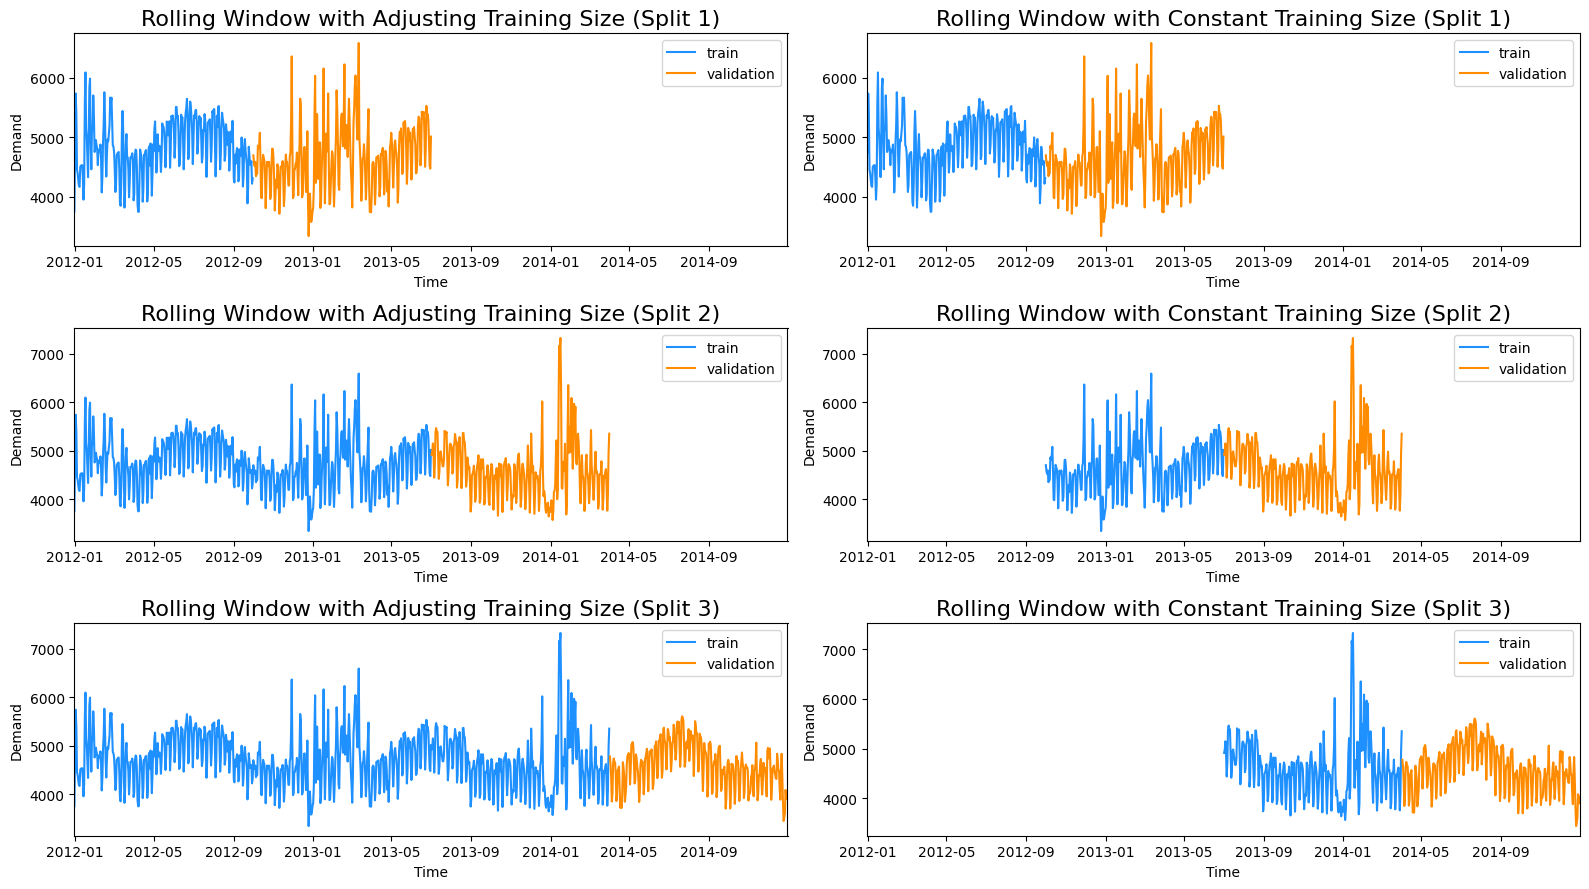

In [122]:
# constant training size vs. adjusting
from datetime import datetime, date 

f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([sample_df.Time.min(), sample_df.Time.max()])
    ax[i, 1].set_xlim([sample_df.Time.min(), sample_df.Time.max()])
    
plt.tight_layout()
plt.show()

In [123]:
# Main modelling
train_size = int(0.85 * len(sample_df)) # 85% for training
test_size = len(sample_df) - train_size

univariate_df = sample_df[['Time', 'Demand']].copy()
univariate_df.columns = ['ds', 'y'] # compatible with modelling process

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

932 165


In [124]:
# Models:
# - Linear models: self-created features
# - Facebook Prophet: https://github.com/facebook/prophet
# - ARIMA: 
# - LSTM: 
# Metrics: RMSE

In [125]:
# Linear regression - features
# - Lags of time series
# - Window statistics: Max/min/Average/median/Window variance
# - Date and time features: Minute of an hour, hour of a day, day of the week, holiday/a special event
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

for i in range(6, 25): # lag=6
    sample_df["lag_{}".format(i)] = sample_df.Demand.shift(i)

sample_df["hour"] = sample_df.Time.dt.hour
sample_df["day_of_week"] = sample_df.Time.dt.day_of_week

lr_features = [col for col in sample_df.columns if col.startswith('lag')] + ['hour', 'day_of_week', 'Holiday']
X = sample_df.loc[:, lr_features].fillna(method='bfill')
y = sample_df.Demand

X_train, X_test, y_train, y_test = X.iloc[:train_size], X.iloc[train_size:], y.iloc[:train_size], y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression().fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

root_mean_squared_error(y_test, y_pred)

271.78034766920723

In [126]:
from sklearn.metrics import root_mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima_model import ARIMA


# Train the model
model = Prophet()
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
rmse = root_mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']) # y_pred might contains many components, filter the proper one only
rmse

11:05:27 - cmdstanpy - INFO - Chain [1] start processing
11:05:27 - cmdstanpy - INFO - Chain [1] done processing


251.85233684943702

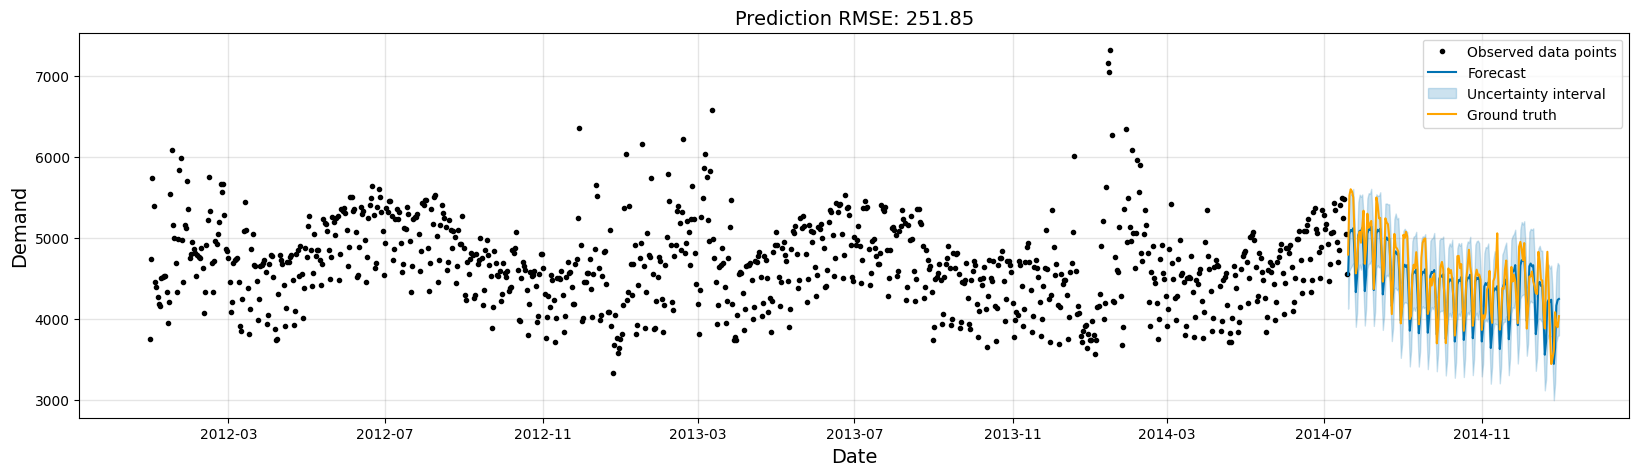

In [127]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction RMSE: {rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Demand', fontsize=14)

plt.show()

In [128]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1)).fit()

# Prediction with ARIMA
y_pred = model.forecast(len(x_valid))

# Calcuate metrics
rmse = root_mean_squared_error(y_valid, y_pred)
rmse

447.8544071531273

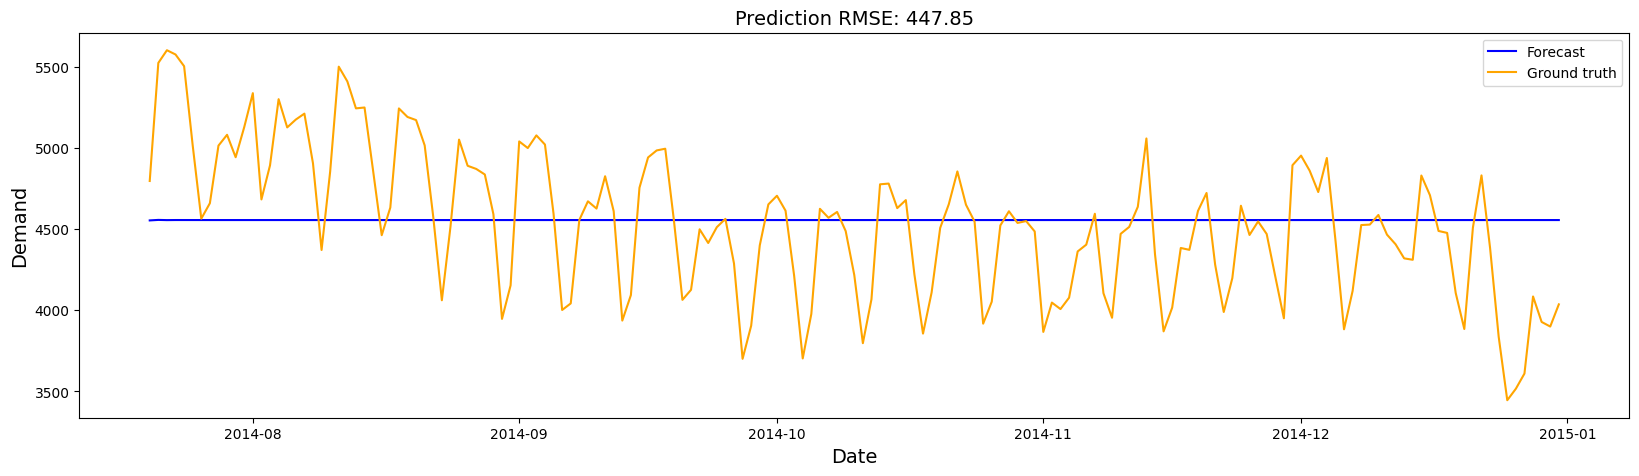

In [129]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)

sns.lineplot(x=x_valid['ds'], y=y_pred, ax=ax, color='blue', label='Forecast')
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction RMSE: {rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Demand', fontsize=14)

plt.show()

In [130]:
# LSTM, but need more preprocessing (more scale with data, sample to H still RMSE=255)
# - Create the dataset, ensure all data is float.
# - Normalize the features.
# - Split into training and test sets.
# - Convert an array of values into a dataset matrix. (proper format for deep learning)
# - Reshape into X=t and Y=t+1.
# - Reshape input to be 3D (num_samples, num_timesteps, num_features).
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

828 165


In [131]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
828/828 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0326 - val_loss: 0.0042
Epoch 2/5
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0114 - val_loss: 0.0078
Epoch 3/5
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 4/5
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081 - val_loss: 0.0046
Epoch 5/5
828/828 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0125 - val_loss: 0.0031


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 128)         │        92,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,195 (1.64 MB)

 Trainable params: 143,731 (561.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 287,464 (1.10 MB)

In [132]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
rmse = root_mean_squared_error(y_test[0], test_predict[:,0])
rmse

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


223.10120501293898

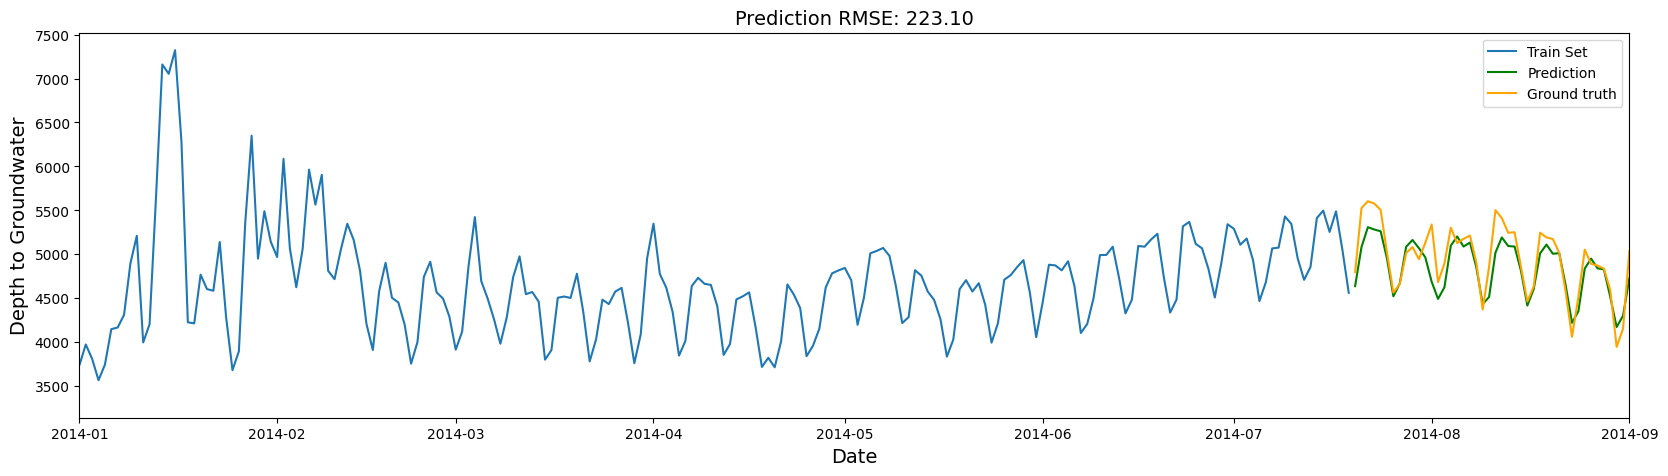

In [133]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction RMSE: {rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_xlim([date(2014, 1, 1), date(2014, 9, 1)])

plt.show()

In [134]:
# Try higher level sampling

In [135]:
# 2. Multivariates


In [138]:
feature_columns = ['Temperature','Holiday']
target_column = ['Demand']

train_size = int(0.85 * len(df))

multivariate_df = df[['Time'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,Temperature,Holiday
0,2011-12-31 13:00:00,4382.825174,21.40,True
1,2011-12-31 13:30:00,4263.365526,21.05,True
2,2011-12-31 14:00:00,4048.966046,20.70,True
3,2011-12-31 14:30:00,3877.563330,20.55,True
4,2011-12-31 15:00:00,4036.229746,20.40,True


In [140]:
model = Prophet()
#model.add_regressor('Temperature')
#model.add_regressor('Holiday')
#model.add_country_holidays(country_name='US')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
root_mean_squared_error(y_valid, y_pred['yhat'])

11:18:22 - cmdstanpy - INFO - Chain [1] start processing
11:18:38 - cmdstanpy - INFO - Chain [1] done processing


602.1804157887126